# Generative models; Diffusion Models

**Diffusion Models** ([Sohl-Dickstein et al., 2015](https://arxiv.org/pdf/1503.03585), [Ho et al., 2020](https://arxiv.org/pdf/2006.11239), [Rombach et al., 2022](https://arxiv.org/pdf/2112.10752)) are last, but certainly not least category of generative models we will learn about. They are inspired by the diffusion process, namely is the movement of particles move from an area of high concentration to an area of low concentration until equilibrium is reached at temperatures above absolute zero $\tau > 0$ K. The result of diffusion is a gradual mixing of substances, that will eventually result in complete mixing:

[![](https://upload.wikimedia.org/wikipedia/commons/9/90/Diffusion_microscopic_picture.gif)]()

*source: Wikipedia*

Diffusion models mimic the thermal diffusion process by gradually adding noise $T \to \infty$ times to the 
dat until it is degraded to random noise drawn from probability distributiona $\pi(x)h:

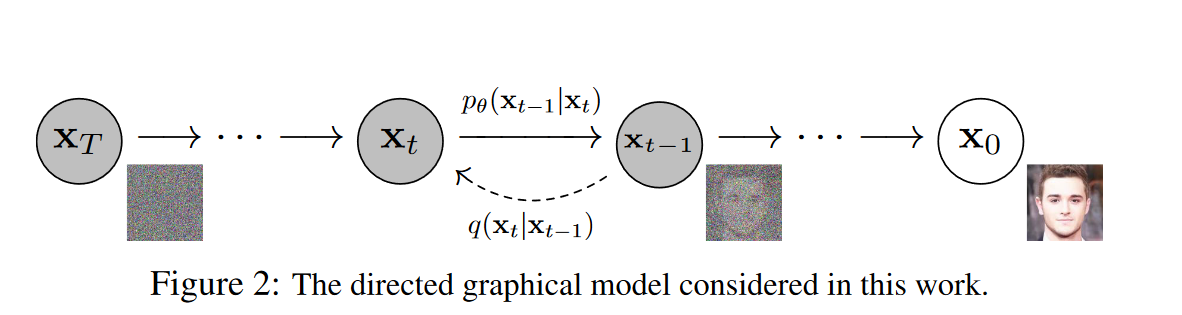
*source: [Ho et al., 2020](https://arxiv.org/pdf/2006.11239)

The model is able to generate new observations by traversing this process in the reverse order: from noise to data. A training goal is to find proper masks representing each step of the reverse diffusion process. .

By definition, the diffusion process is modelled as a **Markov chain on a measurable state space**, where the transition probability is represented by the **diffusion coefficient** $D_\pi(x|x^\prime, \beta)$, where $\beta$ is the **rate of diffusion** (*variance*):
$$\pi(x) = \int D_\pi(x|x^\prime, \beta) \pi(x^\prime) dx^\prime $$
in particular:
$$q(x_t|x_{t-1}) = D_\pi(x_t|x_{t-1}, \beta_t)$$

We assume that $\pi(x)$ is analytically solvable, e.g. it is an isotropic Gaussian distribution, thus the noise added in the single diffusion step can also be represented as a random variable drawn from the Gaussian distribution:

$$q(x_t|x_{t-1}) = \mathcal{N}(x_{t-1},\sqrt{1 - \beta_t}x_{t-1}, \beta_t \bf{I})$$

Moreover,  we assume that the sequence $\{\beta_t \in (0,1)\}_i^T$ (a *variance schedule*) is strictly increasing - the further we move from the original data $x_0$, the more noise we add to it.

At the time step $T$, we get:
$$q(x_{0:T}) = q(x_0)\prod_{t=1}^Tq(x_t|x_{t-1})$$

Reverse diffusion behaves almost exactly the same:

$$ p(x_0) = \int p(x_{0:T})dx_{0:T} $$

or:

$ p(x_{0:T}) = p(x_T)\prod_{t=1}^T p(x_{t-1}|x_t) $ ,

where $ x_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) $ 

Our goal is to train a model that represents the reverse diffusion process for every $x_0$. Mathematically speaking, our goal is to approximate $p(x)$ with $p_\theta(x_0)$ such that:
$$p_\theta(x_0) = p_\theta(x_T)\prod_{t=1}^T p_\theta(x_{t-1}|x_t) \; \mathrm{where} \;  p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$$


As a result, we want to minimize the entropy between the diffusion $q(x_0)$ and the approximated diffusion $p_\theta(x_0)$:

$$
\begin{aligned}
L
&= - \mathbb{E}_{q(x_0)} \log p_\theta(x_0) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \int p(x_{0:T})dx_{0:T} \Big) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \int q(x_{0:T} \vert x_0) \frac{p_\theta(x_{0:T})}{q(x_{0:T} \vert x_0)} dx_{0:T} \Big) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \mathbb{E}_{q(x_{0:T})} \frac{p_\theta(x_{0:T})}{q(x_{0:T})} \Big)
\end{aligned}
$$

By Jensen inequality:

$$
\begin{aligned}
L
&\leq - \mathbb{E}_{q(x_{0:T})} \log \frac{p_\theta(x_{0:T})}{q(x_{0:T} \vert \mathbf{x}_{0})} \\
&= \mathbb{E}_{q(x_{0:T})}\Big[\log \frac{q(x_{0:T} \vert \mathbf{x}_{0})}{p_\theta(x_{0:T})} \Big] \\
&= \mathbb{E}_q \Big[ \log\frac{\prod_{t=1}^T q(x_t\vert x_{t-1})}{ p_\theta(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \vert x_t) } \Big] = L_\text{ELBO}
\end{aligned}
$$

Finally, our goal is to maximize $L_\text{ELBO}$:
$$p_{\theta^*}(x_{t_1} \vert x_t) = \underset{p_{\theta}(x_{t_1} \vert x_t)}{\text{argmax}} \: L_\text{ELBO}$$

However, we must rewrite  $L_\text{ELBO}$  to make it computationally trackable. After some transformations, we get: 


$$
\begin{aligned}
L_\text{ELBO} &= \mathbb{E}_q \Big[ \log\frac{\prod_{t=1}^T q(x_t\vert x_{t-1})}{ p_\theta(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \vert x_t) } \Big] \\
&= \mathbb{E}_q [\underbrace{D_\text{KL}(q(x_T \vert x_0) \parallel p_\theta(x_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q(x_{t-1} \vert x_t, x_0) \parallel p_\theta(x_{t-1} \vert x_t))}_{L_{t-1}} - \underbrace{\log p_\theta(x_0 \vert x_1)}_{L_0} ] 
\end{aligned}
$$

$\beta_t$ is constant, thus $(q(x_T \vert x_0)$ has no learnable parameters and  $p_\theta(x_T)$ is just a random noise drawn from  $\mathcal{N}(\mathbf{0}, \mathbf{I})$, as a result, $L_T$ is constant and negligible. For every $t \geq 2$ $L_{t-1}$ is a KL divergence between two Gaussian distributions, thus it is easy to find its closed form. $L_0$ is the only non-parametric element of the loss function.

Auxiliary function, that allows us to expand the dimensionality of a vector: 

Before the training begins, we must define the **positional encoding** of every time step. The architecture itself will be static, with no built-in mechanism for controlling the order of data. Hence, we must explicitly add the positional information to the model.

We cannot do this by merely adding the time index $t$ - the model will not be able to comprehend such information. As a result, we must embed the time data in a proper latent space. We will do this by using the **positional encoding**  scheme introduced together with **attention models** [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). For every $t = {1,2,\dots,T}$ we define embedding $\mathcal{E}(t)$ as: 

$$
\begin{align}
\mathcal{E}(t, 2i) &=& \sin\Big(\frac{t}{n^{2i/d}}\Big)\\
\mathcal{E}(t, 2i+1) &=& \cos\Big(\frac{t}{n^{2i/d}}\Big)
\end{align}
$$

where $\mathcal{E}(t, j)$ is a single term of a matrix $\mathcal{E}(t)$ with indices $t$ and $j$ , $d$ is a dimension of the output embedding, $i = 0,2,\dots,d/2$ is a row position, and $n$ is a fixed scalar (usually 10 000).

alternatively [(Tancik et al. 2020)](https://arxiv.org/abs/2006.10739):

We will use **U-Net** [(Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597) as a neural network architecture:
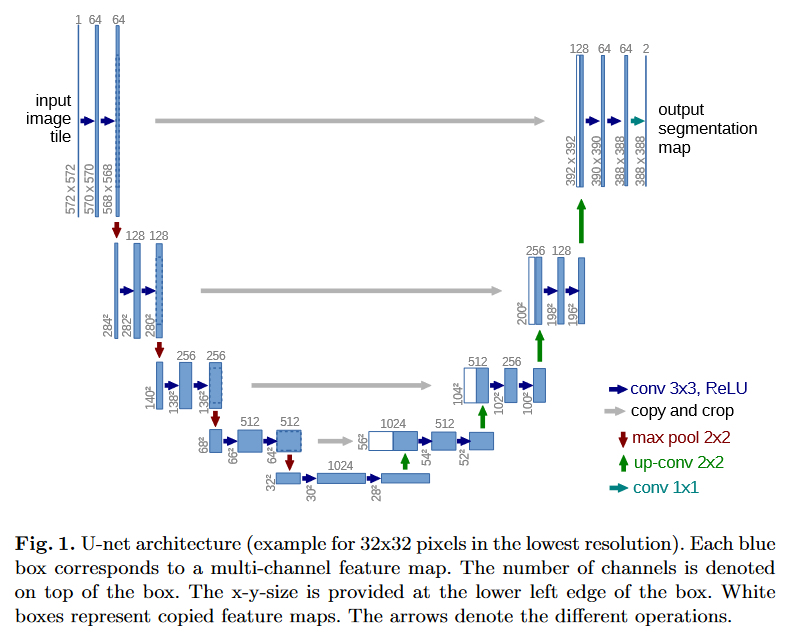
*źródło: [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)*

U-Net is a convolutional neural network that was developed for image segmentation, a computer vision technique that partitions a digital image into discrete groups of pixels, so-called image segments. It is often used to detect objects, parts of a picture that share certain characteristics, etc. 

We model the diffusion process as a Markov chain with Gaussian distributed variables. As a result, we could easily compute the value of $x_t$ in every step. Assume that  $\alpha = 1 -\beta$ and $\bar{\alpha}  = \prod_{i=1}^t \alpha_i$, then:

$$
\begin{aligned}
x_t &= \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1}  \\
&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t (1 - \alpha_{t-1})} \boldsymbol{\epsilon}_{t-2}  + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1}  \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
\end{aligned}
$$
where $\boldsymbol{\epsilon}, \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

Finally, we get a transition probability from $x_0$ to $x_t$:

$$q(x_t \vert x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t)\mathbf{I})$$

Written as a code:

$q(x_t \vert x_{t-1})$ is a Gaussian process, thus its inverse: $q(x_{t-1} \vert x_t)$ also has this property. Moreover, we could easily find its explicit form, assuming that it is conditioned on  $x_0$: 

$q(x_{t-1} \vert x_t, x_0) = \mathcal{N}(x_{t-1},\tilde{\mu}(x_t,x_0), \tilde{\beta_t} \bf{I})$

It turns out that parameters $\tilde{\mu}$ and $\tilde{\beta_t}$ of such distribution are equal to:
$$
\begin{aligned}
\tilde{\beta}_t 
&= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t \\
\tilde{\mu}_t (x_t, x_0)
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} x_0\\
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t) \\
&= \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)
\end{aligned}
$$



Now, we must find a good parametrization of the reverse diffusion process $p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$, namely we are interested in finding the $\mu_\theta$ that will approximate $\tilde{\mu_t}$ for every $t$. After some calculations, the loss function term $L_{t-1}$ reduces to mean squared error between  $\tilde{\mu_t}$ and  $\mu_\theta$:

$$
\begin{aligned}
L_{t-1} 
&\approx \mathbb{E}_{q} \Big[\frac{1}{2 \| \Sigma_\theta(x_t, t) \|^2_2} \| \tilde{\mu}_t(x_t, x_0) - \mu_\theta(x_t, t) \|^2 \Big] \\
&= \mathbb{E}_{x_0, \boldsymbol{\epsilon}} \Big[\frac{1}{2 \| \Sigma_\theta \|^2_2} \| \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big) - \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(x_t, t) \Big) \|^2 \Big] \\
&= \mathbb{E}_{x_0, \boldsymbol{\epsilon}} \Big[\frac{ \beta_t^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \Sigma_\theta \|^2_2} \|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(x_t, t)\|^2 \Big] \\
\end{aligned}
$$

Moreover, we can simplify the loss function (and improve the quality of the model!) by omitting the  $\frac{ \beta_t^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \Sigma_\theta \|^2_2}$ coefficient. After this step, the loss function takes the form:
$$
\begin{aligned}
L_{t-1}^\text{simple}
&= \mathbb{E}_{t, x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(x_t, t)\|^2 \Big] \\
&= \mathbb{E}_{t, x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big]
\end{aligned}
$$

Lastly, calculating the expected value of $L_{t-1}$ is not necessary; we can use the **reparametrization trick** and just calculate the value for a random batch of data - when training is long enough, the result will be roughly the same. 

Definitions of sampling functions:

Optimizer: